In [1]:
from lib import Augmentation_methods
from lib import data_preparation

import matplotlib.pyplot as plt
from scipy.signal import stft
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2
from IPython.display import clear_output

2023-01-06 16:30:49.132574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
BASEDIR = Path("/store/projects/fallki/")
FAKEDIR = BASEDIR / "Fake-Events" / "2. Fake-Events Messung"

# BASEDIR = pathlib.Path('/store/projects/fallki/')
# FAKEDIR = pathlib.Path('Fake-Events/2. Fake-Events Messung/')
df_fake = pd.read_parquet(BASEDIR / FAKEDIR / 'gSensoren_FakeEvents.parquet')

In [4]:
dummy_lab_data = data_preparation.fake_lab_data()
dummy_data = dummy_lab_data[0]
dummy_data_df =pd.DataFrame(dummy_data,columns=['z'])
dummy_data_df

/home/ing2146/Final/SNEHA/lib/data_preparation.py:202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  All_Events_Data = np.array(All_Events_Data)[shuffler]
/home/ing2146/Final/SNEHA/lib/data_preparation.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_fake_dummy_Data = np.array(df_fake_dummy_Data)


,z
0,"[1028.0, 1030.0, 1028.0, 1030.0, 1030.0, 1028...."
1,"[1038.0, 1040.0, 1040.0, 1040.0, 1042.0, 1038...."
2,"[1038.0, 1040.0, 1042.0, 1036.0, 1036.0, 1036...."
3,"[1039.0, 1039.0, 1037.0, 1039.0, 1040.0, 1039...."
4,"[1030.0, 1030.0, 1032.0, 1032.0, 1030.0, 1028...."
...,...
67,"[1026.0, 1026.0, 1024.0, 1026.0, 1026.0, 1026...."
68,"[1039.0, 1037.0, 1035.0, 1039.0, 1037.0, 1041...."
69,"[1036.0, 1038.0, 1040.0, 1036.0, 1036.0, 1036...."
70,"[1028.0, 1026.0, 1029.0, 1026.0, 1026.0, 1032...."


#### Data Preparation

In [5]:
def SignalToSpectrum(signal, samplerate=1600):
    SIGNAL_LENGTH = samplerate * 10
    F = stft(signal[:SIGNAL_LENGTH], 1600, nperseg=128)[2]
    F = F[2:,]
    return np.expand_dims(np.abs(F), axis=2) # Add extra dimension for TF Conv2D

In [6]:
fakeEvents = pd.read_parquet(FAKEDIR / "gSensoren_FakeEvents.parquet")

In [7]:
L = []
for (teensy, event, run, rep), ss in df_fake.groupby(["teensy", "experiment", "run", "rep"]):
    L.append({"event": event,
              "run": run,
              "istSturz": int(event == "Dummy"),
              "signalLenght": len(ss["z"]),
              "spectrum": SignalToSpectrum(ss["z"])})
df = pd.DataFrame.from_dict(L)
df.drop('run', inplace=True, axis=1)

In [8]:
# normalize the spectrum to facilitate training
df["normalizedSpectrum"] = df["spectrum"] / df["spectrum"].map(np.max).max()

In [9]:
df

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,1.5L Flasche,0,15976,"[[[220.68784142956994], [0.11347713586453584],...","[[[0.32260105096654695], [0.000165880653204249..."
1,1.5L Flasche,0,16038,"[[[220.7760221941459], [0.4810628935081976], [...","[[[0.3227299534341363], [0.0007032167881178003..."
2,1.5L Flasche,0,15997,"[[[220.56718777220033], [0.12610317723679612],...","[[[0.32242467968837296], [0.000184337375558562..."
3,1.5L Flasche,0,15994,"[[[220.36006931821052], [0.1674748618352673], ...","[[[0.32212191434118004], [0.00024481442243739]..."
4,1.5L Flasche,0,15981,"[[[220.2963925540494], [0.10592890921923297], ...","[[[0.3220288317730265], [0.0001548466703942562..."
...,...,...,...,...,...
1074,Wasserkasten,0,16016,"[[[218.37627577851634], [0.055410840780798054]...","[[[0.3192220088608402], [8.099945767302386e-05..."
1075,Wasserkasten,0,16022,"[[[218.40860650609568], [0.18719544272495878],...","[[[0.3192692698545952], [0.0002736419286537467..."
1076,Wasserkasten,0,16035,"[[[218.3026629620155], [0.14587216622705163], ...","[[[0.31911440179099004], [0.000213235644640766..."
1077,Wasserkasten,0,16038,"[[[217.99264491329228], [0.4175814757468029], ...","[[[0.31866121801933844], [0.000610419776945764..."


In [10]:
#shuffle the final dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [11]:
X = np.stack(df["normalizedSpectrum"].to_list())
y = df["istSturz"].to_numpy()

### Model

#### Cross-validation

In [12]:
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md
# https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [14]:
# Model configuration
#batch_size = 50
loss_function = "binary_crossentropy"
no_epochs = 75
optimizer = "adam"
verbosity = 0
num_folds = 5

In [15]:
# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

In [16]:
# defind array fot ROC, Precision-recall curve and confusion martrix
roc_values = []
precision_recall_values = []
auc = []
confusion_matrices = []

In [17]:
# Define the K-fold Cross Validator
skfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skfold.split(X, y):
    mdl = Sequential()
    mdl.add(Conv2D(8, (63, 5), activation="relu", input_shape=(63, 251, 1)))
    mdl.add(MaxPooling2D((1, 4)))
    mdl.add(Flatten())
    mdl.add(Dense(1,activation="sigmoid"))
    #mdl.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    #mdl.summary()

    # Compile the model
    mdl.compile(loss=loss_function,
                    optimizer=optimizer,
                    metrics=['accuracy'])


      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = mdl.fit(X[train], y[train],
                  epochs=no_epochs,
                  verbose=verbosity)

    # Generate generalization metrics
    scores = mdl.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {mdl.metrics_names[0]} of {scores[0]}; {mdl.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Confusion Matrix
    # Predict the labels for the test set
    y_pred = mdl.predict(X[test,])
    
    # Convert the predicted labels to a binary form
    y_pred_binary = np.where(y_pred > 0.10, 1, 0)
    
    
    # ROC AND PRECISION RECALL VALUES
    fpr, tpr, thresholds = roc_curve(y[test], y_pred)
    roc_values.append((fpr, tpr,thresholds))
    
    
    precision, recall, thresholds_1 = precision_recall_curve(y[test], y_pred)
    precision_recall_values.append((precision, recall,thresholds_1)) 
    
    auc = roc_auc_score(y[test], y_pred)
     
    #confusion matrix
    confusion_matrices.append(confusion_matrix(y[test], y_pred_binary))


    # Increase fold number
    fold_no = fold_no + 1

2023-01-06 16:31:59.139212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.13264749944210052; accuracy of 95.83333134651184%
7/7 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.0983981043100357; accuracy of 95.37037014961243%
7/7 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.08710179477930069; accuracy of 98.14814925193787%
7/7 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.16384418308734894; accuracy of 91.66666865348816%
7/7 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 5 ...


In [18]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.13264749944210052 - Accuracy: 95.83333134651184%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0983981043100357 - Accuracy: 95.37037014961243%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.08710179477930069 - Accuracy: 98.14814925193787%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.16384418308734894 - Accuracy: 91.66666865348816%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.10643283277750015 - Accuracy: 96.74418568611145%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 95.55254101753235 (+- 2.161908073266586)
> Loss: 0.1176848828792572
-------------------------

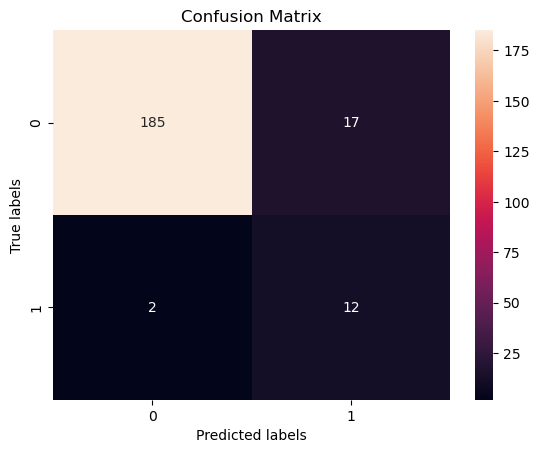

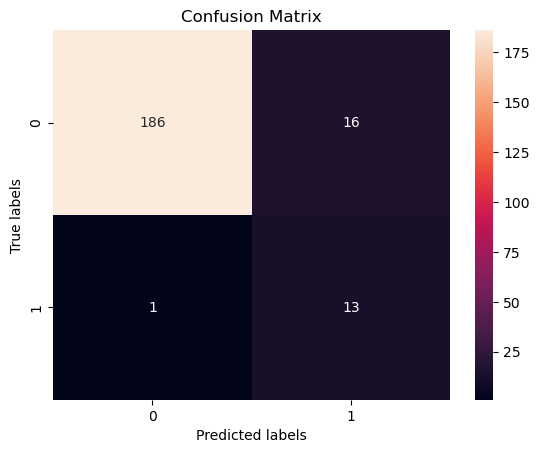

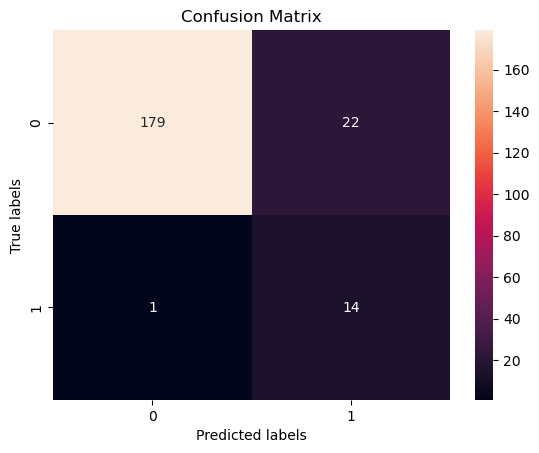

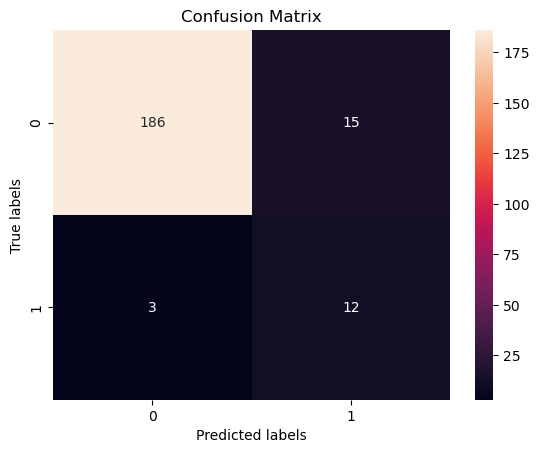

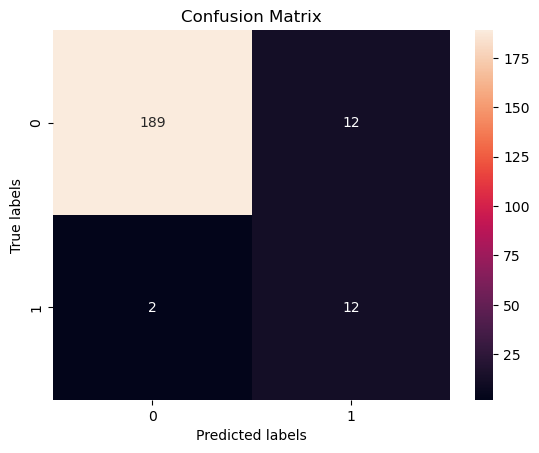

In [19]:
# Plot the confusion matrix values for each fold on the same graph
for cm in confusion_matrices:
    ax= pyplot.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    pyplot.show() 

# Show the plot
plt.show()

In [20]:
pyplot.rcParams.update({'font.size': 8})

In [ ]:
tprs = []
base_fpr = np.linspace(0, 1, 101)
pyplot.figure(figsize=(5, 5))
pyplot.axes().set_aspect('equal', 'datalim')

For fold 1 optimal Threshold=0.070680, G-Mean=0.899
For fold 2 optimal Threshold=0.070963, G-Mean=0.952
For fold 3 optimal Threshold=0.099900, G-Mean=0.944
For fold 4 optimal Threshold=0.053196, G-Mean=0.936
For fold 5 optimal Threshold=0.094253, G-Mean=0.934
mean Threshold=0.006047, G-Mean=0.919


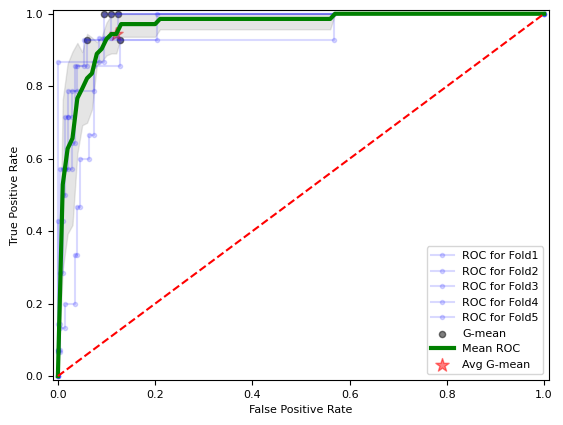

In [29]:
# Plot the ROC and precision-recall values for each fold on the same graph
tprs = []

# Calculate the mean values of FPR and TPR for the ROC curve
mean_fpr = sum(fpr[i] for i in range(len(roc_values))) / len(roc_values)
mean_tpr = sum(tpr[i] for i in range(len(roc_values))) / len(roc_values)

# Calculate the mean values of precision and recall for the precision-recall curve
mean_precision = sum(precision[i] for i in range(len(precision_recall_values))) / len(precision_recall_values)
mean_recall = sum(recall[i] for i in range(len(precision_recall_values))) / len(precision_recall_values)

i = 1
j = 1
    
# ROC CURVE
for fpr, tpr,thresholds in roc_values:
    
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    print('For fold '  +str(i), 'optimal Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr,'b', alpha=0.15, marker='.', label='ROC for Fold' +str(i))
    
    tpr_new = np.interp(base_fpr, fpr, tpr)
    tpr_new[0] = 0.0
    tprs.append(tpr_new)
    
   
    if i == num_folds:
        pyplot.scatter(fpr[ix], tpr[ix],s=20,alpha=0.5, marker='o', color='black', label='G-mean')
        pyplot.legend()
    else:
        pyplot.scatter(fpr[ix], tpr[ix],s=20,alpha=0.5, marker='o', color='black')  
        pyplot.legend()
        
    i = i + 1
     
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


gmeans_new = sqrt(mean_tprs * (1-base_fpr))
# locate the index of the largest g-mean
iy = argmax(gmeans_new)
print('mean Threshold=%f, G-Mean=%.3f' % (thresholds[iy], gmeans_new[iy]))

pyplot.plot(base_fpr, mean_tprs, 'g',linewidth=3.0, label='Mean ROC')
pyplot.scatter(base_fpr[ix], mean_tprs[ix],s=100,alpha=0.5, marker="*", color='Red', label='Avg G-mean')
pyplot.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

pyplot.plot([0, 1], [0, 1],'r--')
pyplot.xlim([-0.01, 1.01])
pyplot.ylim([-0.01, 1.01])
pyplot.ylabel('True Positive Rate')
pyplot.xlabel('False Positive Rate')
pyplot.legend()
pyplot.show()



In [36]:
prc = []
base_recall = np.linspace(0, 1, 101)

For fold 1 Best Threshold=0.484004, F-Score=0.714
For fold 2 Best Threshold=0.244826, F-Score=0.727
For fold 3 Best Threshold=0.380049, F-Score=0.929
For fold 4 Best Threshold=0.099501, F-Score=0.605
For fold 5 Best Threshold=0.277623, F-Score=0.759


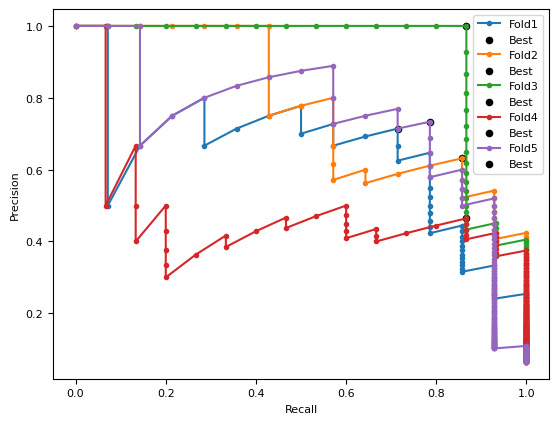

In [38]:
ix = 0 
j = 1
# PRECISION RECALL CURVE
for precision, recall, thresholds_1 in precision_recall_values:
    
     # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('For fold '  +str(j),'Best Threshold=%f, F-Score=%.3f' % (thresholds_1[ix], fscore[ix]))

    pyplot.plot(recall, precision, marker='.', label='Fold' + str(j))
    
    
    pyplot.scatter(recall[ix], precision[ix],s=20, marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    
    j = j + 1


# Show the plot
pyplot.show()